<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/Workshop_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# สร้างและฝึกโมเดล CNN ด้วย TensorFlow

## 1.ติดตั้ง TensorFlow

In [ ]:
!pip install tensorflow

## 2.Import Library และกำหนดค่า Parameter

In [2]:
import tensorflow as tf

load_img = tf.keras.preprocessing.image.load_img
img_to_array = tf.keras.preprocessing.image.img_to_array
array_to_img = tf.keras.preprocessing.image.array_to_img
Adam = tf.keras.optimizers.Adam
fashion_mnist = tf.keras.datasets.fashion_mnist
to_categorical = tf.keras.utils.to_categorical
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
load_model = tf.keras.models.load_model

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly import subplots
import plotly

In [3]:
# กำหนดค่า Parameter ที่จำเป็น
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
VAL_SIZE = 0.2
RANDOM_STATE = 99

BATCH_SIZE = 128

## 3.Load Dataset

In [4]:
(train_data, y), (test_data, y_test) = fashion_mnist.load_data()

print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1], " rows:", train_data.shape[2])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1], " rows:", train_data.shape[2])

4422102/4422102 [==============================] - 0s 0us/step
Fashion MNIST train -  rows: 60000  columns: 28  rows: 28
Fashion MNIST test -  rows: 10000  columns: 28  rows: 28


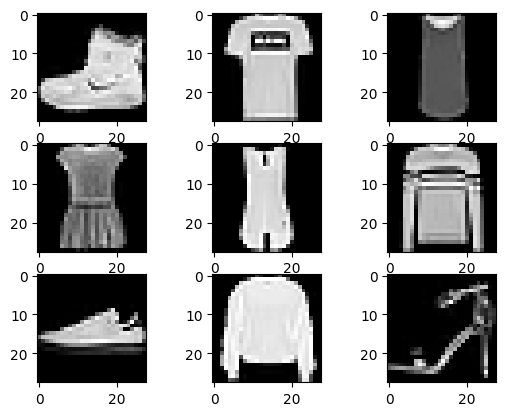

In [5]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))

plt.savefig('fashion_mnist.jpeg', dpi=300)

In [6]:
# ขยายมิติของ Dataset
print(train_data.shape, test_data.shape)

train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

print(train_data.shape, test_data.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# ทำ Scaling
train_data = train_data / 255.0
test_data = test_data / 255.0

In [8]:
# เข้ารหัสผลเฉลยแบบ One-hot Encoding
y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:10]

(60000, 10) (10000, 10)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

## 4.แบ่งข้อมูลสำหรับ Train และ Test

In [9]:
# แบ่งข้อมูลสำหรับ Train และ Test โดยการสุ่มในสัดส่วน 80:20
x_train, x_val, y_train, y_val = train_test_split(train_data, y, test_size=VAL_SIZE, random_state=RANDOM_STATE)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [10]:
# นิยาม Function สำหรับ Plot Loss และ Accuracy
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))

    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    plotly.offline.iplot(fig, filename='accuracy-loss')

## 5.Image Augmentation

In [11]:
# นิยามวิธีการทำ Image Augmentation
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range = 0.2,       # Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
)

datagen.fit(x_train)

## 6.สร้าง Model

In [12]:
# นิยาม Model
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(28, 28, 1), name = 'conv2d1'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm1'))
model.add(tf.keras.layers.Activation("relu", name = 'relu1'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout1'))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', name = 'conv2d2'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm2'))
model.add(tf.keras.layers.Activation("relu", name = 'relu2'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name = 'maxpool2d1'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout2'))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', name = 'conv2d3'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm3'))
model.add(tf.keras.layers.Activation("relu", name = 'relu3'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout3'))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', name = 'conv2d4'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm4'))
model.add(tf.keras.layers.Activation("relu", name = 'relu4'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name = 'maxpool2d2'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout4'))


#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten(name = 'flatten1'))
model.add(tf.keras.layers.Dense(256, name = 'dense1'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm5'))
model.add(tf.keras.layers.Activation("relu", name = 'relu5'))
model.add(tf.keras.layers.Dropout(0.30, name = 'dropout5'))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'dense2'))

In [13]:
# Compile Model
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
# นิยามการทำ Checkpoint เพื่อ Save Model เฉพาะ Epoch ที่ค่า val_loss น้อยกว่ารอบก่อนหน้า
filepath="weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

## 7.Train Model

In [ ]:
# Train Model
NO_EPOCHS = 15
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, validation_data = (x_val, y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                              callbacks=callbacks_list)

## 8.Evaluation

In [16]:
# Plot Loss และ Accuracy
plot_accuracy_and_loss(history)

In [17]:
# Load Weight ของ Model ที่ค่า val_loss น้อยที่สุด
predict_model = load_model(filepath)

In [18]:
# Evaluation
score = predict_model.evaluate(test_data, y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.24169068038463593
Test Accuracy: 0.9118000268936157


## 9.Predict

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ชื่อคลาสสำหรับ Fashion MNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

1/1 [==============================] - 0s 36ms/step
True class: Trouser
Predicted class: Trouser


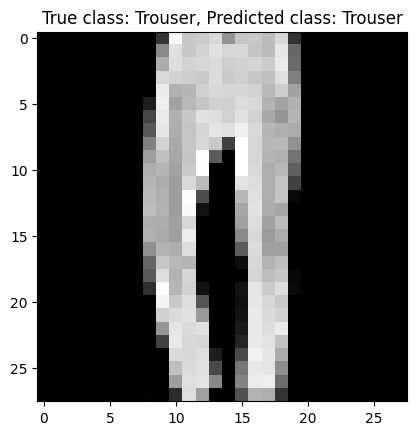

Class T-shirt/top: 0.0000
Class Trouser: 1.0000
Class Pullover: 0.0000
Class Dress: 0.0000
Class Coat: 0.0000
Class Sandal: 0.0000
Class Shirt: 0.0000
Class Sneaker: 0.0000
Class Bag: 0.0000
Class Ankle boot: 0.0000


In [25]:
# เลือกภาพสุ่มจากชุดข้อมูล validation
index = 3  # คุณสามารถเปลี่ยนค่า index เพื่อเลือกภาพอื่น
image_to_predict = x_val[index:index+1]  # เลือกภาพเดียว

# ทำการคาดการณ์
predictions = predict_model.predict(image_to_predict)

# แปลผลลัพธ์เป็นป้ายชื่อ
predicted_class = np.argmax(predictions, axis=1)[0]
true_class = np.argmax(y_val[index])

print(f"True class: {class_names[true_class]}")
print(f"Predicted class: {class_names[predicted_class]}")

# แสดงภาพที่คาดการณ์
plt.imshow(image_to_predict.reshape(28, 28), cmap='gray')
plt.title(f"True class: {class_names[true_class]}, Predicted class: {class_names[predicted_class]}")
plt.show()

# แสดงความน่าจะเป็นสำหรับทุกคลาส
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}: {predictions[0][i]:.4f}")